# Analyse des performances de l'entreprise et des tendances globales

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt

##### Importation du csv dans un dataframe

In [4]:
df_ = pd.read_csv('dataset/clean_online_retail.csv')
df = df_.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797815 entries, 0 to 797814
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      797815 non-null  object 
 1   StockCode    797815 non-null  object 
 2   Description  797815 non-null  object 
 3   Quantity     797815 non-null  int64  
 4   InvoiceDate  797815 non-null  object 
 5   Price        797815 non-null  float64
 6   Customer ID  797815 non-null  int64  
 7   Country      797815 non-null  object 
 8   TotalPrice   797815 non-null  float64
 9   cancelled    797815 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 60.9+ MB


## Chiffre d'affaire de l'entreprise

In [6]:
# Convertir la colonne "InvoiceDate" en type datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Filtrer les données pour l'année 2010
df_2010 = df[(df['InvoiceDate'].dt.year == 2010)]

# Calculer le chiffre d'affaires en 2010
ca_2010 = df_2010['TotalPrice'].sum()

# Filtrer les données pour l'année 2011
df_2011 = df[(df['InvoiceDate'].dt.year == 2011)]

# Calculer le chiffre d'affaires en 2011
ca_2011 = df_2011['TotalPrice'].sum()

print("Chiffre d'affaires en 2010 :", ca_2010)
print("Chiffre d'affaires en 2011 :", ca_2011)

Chiffre d'affaires en 2010 : 7903701.624
Chiffre d'affaires en 2011 : 7726164.564


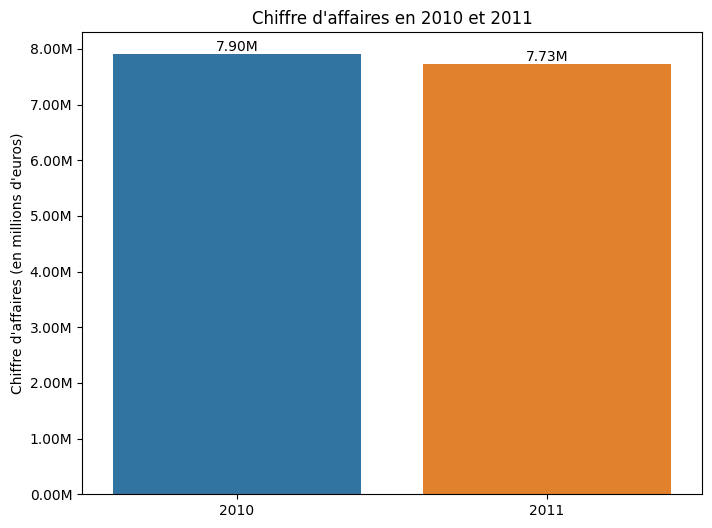

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Créer un DataFrame pour les chiffres d'affaires
ca_df = pd.DataFrame({'Année': ['2010', '2011'], 'Chiffre d\'affaires (en millions d\'euros)': [ca_2010, ca_2011]})

# Agrandir la taille de la figure
plt.figure(figsize=(8, 6))

# Créer le graphique avec Seaborn
ax = sns.barplot(x='Année', y='Chiffre d\'affaires (en millions d\'euros)', data=ca_df)

# Ajouter les labels aux barres
for i, v in enumerate(ca_df['Chiffre d\'affaires (en millions d\'euros)']):
    ax.text(i, v, f'{v/1000000:.2f}M', ha='center', va='bottom')

# Formater les labels de l'axe des y en millions avec 2 décimales
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000000:.2f}M'))

# Ajouter un titre
plt.title('Chiffre d\'affaires en 2010 et 2011')
ax.set(xlabel=None)
# Sauvegarder le graphique dans un dossier "img"
plt.savefig('img/graphique_ca.png')

# Afficher le graphique
plt.show()


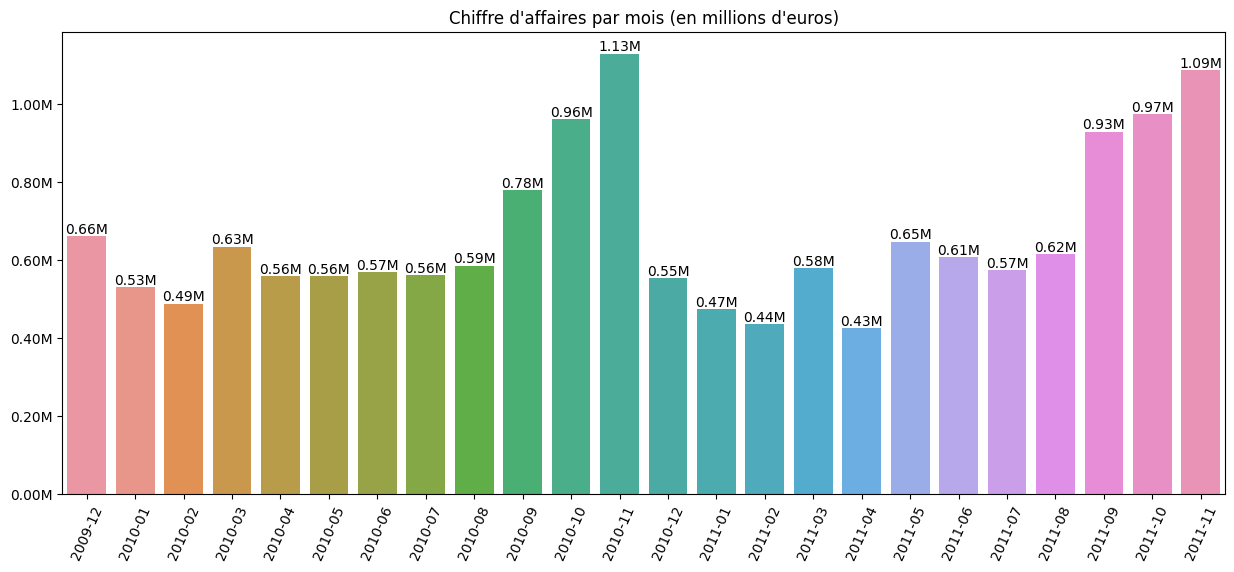

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Convertir la colonne "InvoiceDate" en type datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Filtrer les données pour la plage de dates souhaitée
start_date = pd.to_datetime('2009-12-01')
end_date = pd.to_datetime('2011-11-30')
df_filtered = df[(df['InvoiceDate'] >= start_date) & (df['InvoiceDate'] <= end_date)]

# Calculer le chiffre d'affaires par mois
df_monthly_ca = df_filtered.groupby(df_filtered['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum().reset_index()

# Agrandir la taille de la figure
plt.figure(figsize=(15, 6))

# Créer le graphique avec Seaborn
ax = sns.barplot(x='InvoiceDate', y='TotalPrice', data=df_monthly_ca)

# Ajouter les labels aux barres
for i, v in enumerate(df_monthly_ca['TotalPrice']):
    ax.text(i, v, f'{v/1000000:.2f}M', ha='center', va='bottom')

# Formater les labels de l'axe des x
plt.xticks(rotation=66)

# Formater les labels de l'axe des y en millions avec 2 décimales
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000000:.2f}M'))

# Ajouter un titre
plt.title('Chiffre d\'affaires par mois (en millions d\'euros)')
ax.set(xlabel=None, ylabel=None)
# Sauvegarder le graphique dans un dossier "img"
plt.savefig('img/graphique_ca_mensuel.png')

# Afficher le graphique
plt.show()


## Analyse produits

In [27]:
df_products = df.groupby(['Description'], as_index=False)['Quantity'].agg('sum')
df_products_asc = df_products.sort_values('Quantity').head(10)
df_products_asc['Quantity'] = df_products_asc['Quantity'] * (-1)
df_products_desc = df_products.sort_values('Quantity', ascending=False).head(10)

In [28]:
fig = go.Figure(data=[
    go.Bar(name='Produits les plus vendus', 
           x=df_products_desc['Description'].astype(str), 
           y=df_products_desc['Quantity'],
           marker_opacity=1,
           marker={'color': df_products_desc['Quantity'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_layout(title='Produits les plus vendus',
                  title_x=0.45,
                  xaxis_title="Produits",
                  yaxis_title="Quantité vendue",
                  plot_bgcolor='white')
fig.show()

In [166]:
fig = go.Figure(data=[
    go.Bar(name='Produits avec le plus de retours', 
           x=df_products_asc['Description'].astype(str), 
           y=df_products_asc['Quantity'],
           marker_opacity=1,
           marker={'color': df_products_desc['Quantity'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_layout(title='Produits avec le plus de retours',
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Produits",
                  yaxis_title="Quantité retournée",
                  plot_bgcolor='white')
fig.show()

On observe ici que le produit le plus vendu est le 'World War 2 Glider', on voit également que parmis les produits les plus vendus il y a plusieurs boîtes à gâteau.  
A l'inverse ce sont les 'white cherry lights' qui ont fait l'objet du plus grand nombre de retours, parmis les produits les plus retournés on peut voir qu'il y a beaucoup de décorations.

## Analyse clients

### Montant des dépenses

Cherchons maintenant après les 10 clients qui ont dépensé le plus au cours de ces deux ans, ainsi que les 10 qui ont dépensé le moins

In [167]:
df_customers = df.groupby(['Customer ID', 'Country'], as_index=False)['TotalPrice'].agg('sum')
df_customers_asc = df_customers.sort_values('TotalPrice').head(10)
df_customers_desc = df_customers.sort_values('TotalPrice', ascending=False).head(10)

In [168]:
fig = go.Figure(data=[
    go.Bar(name='Clients qui ont le plus acheté', 
           x=df_customers_desc['Customer ID'].astype(str), 
           y=df_customers_desc['TotalPrice'],
           marker_opacity=1,
           hovertext=df_customers_desc['Country'],
           marker={'color': df_customers_desc['TotalPrice'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_layout(title='Clients qui ont le plus acheté',
                  title_x=0.45,
                  xaxis_title="Customer ID",
                  yaxis_title="Montant Total",
                  plot_bgcolor='white')
fig.show()

On peut voir que le client avec l'ID 18102 est celui qui a dépensé le plus ces deux dernières années avec près de 600k, on sait également qu'il vient du Royaume Uni.  
Parmis les 10 meilleurs clients, la plupart viennent du Royaume Uni ou d'Irlande

In [169]:
fig = go.Figure(data=[
    go.Bar(name='Clients qui ont le moins acheté', 
           x=df_customers_asc['Customer ID'].astype(str), 
           y=df_customers_asc['TotalPrice'],
           marker_opacity=1,
           hovertext=df_customers_desc['Country'],
           marker={'color': df_customers_desc['TotalPrice'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_layout(title='Clients qui ont le moins acheté',
                  title_x=0.45,
                  xaxis_title="Customer ID",
                  yaxis_title="Montant Total Remboursé",
                  plot_bgcolor='white')
fig.show()

On peut voir ici que le client avec l'ID 17399 est celui qui a reçu le plus gros remboursement, pour près de 25k.  
Tout comme pour les meilleurs clients, les moins bons ont l'air de venir pour la plupart du Royaume-Uni ainsi que de l'Irlande.

### Analyse par pays

Il pourrait être intéressant de voir maintenant quels sont les pays dont les clients ont le plus et le moins acheté.

In [173]:
df_countries_purchase = df.groupby(['Country'], as_index=False)['TotalPrice'].agg('sum')
df_countries_purchase_asc = df_countries_purchase.sort_values('TotalPrice').head(10)
df_countries_purchase_desc = df_countries_purchase.sort_values('TotalPrice', ascending=False).head(10)

In [174]:
fig = go.Figure(data=[
    go.Bar(name="Pays avec le plus d'achats", 
           x=df_countries_purchase_desc['Country'].astype(str), 
           y=df_countries_purchase_desc['TotalPrice'],
           marker_opacity=1,
           marker={'color': df_countries_purchase_desc['TotalPrice'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_layout(title="Pays avec le plus d'achats",
                  title_x=0.45,
                  xaxis_title="Pays",
                  yaxis_title="Montant Total",
                  plot_bgcolor='white')
fig.show()

In [175]:
fig = go.Figure(data=[
    go.Bar(name="Pays avec le moins d'achats", 
           x=df_countries_purchase_asc['Country'].astype(str), 
           y=df_countries_purchase_asc['TotalPrice'],
           marker_opacity=1,
           marker={'color': df_countries_purchase_desc['TotalPrice'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_layout(title="Pays avec le moins d'achats",
                  title_x=0.45,
                  title_y=0.97,
                  xaxis_title="Pays",
                  yaxis_title="Montant Total",
                  plot_bgcolor='white')
fig.show()

On observe ici que le Royaume Uni est loin devant en terme de dépenses, avec près de 13.5M d'achat soit 24x plus que l'Irlande qui arrive en seconde position.  
A l'inverse, l'Arabie Saoudite est le pays où les clients ont le moins dépensé : seulement 131 € sur ces deux dernières années.  
On peut également être étonné du positionnement de la République Tchèque parmis les pays qui ont le moins dépensé alors que la plupart des autres pays d'Europe sont parmis le top 10.

Nous allons maintenant nous intéresser aux pays où le nombre unique de clients est le plus élevé et ceux où il est le moins élevé.

In [176]:
df_countries_customers = df.groupby(['Country'], as_index=False)['Customer ID'].agg({'Customer ID': 'nunique'})
df_countries_customers.rename(columns={'Customer ID': 'Customer Count'}, inplace=True)
df_countries_customers_asc = df_countries_customers.sort_values('Customer Count').head(10)
df_countries_customers_desc = df_countries_customers.sort_values('Customer Count', ascending=False).head(10)

In [177]:
fig = go.Figure(data=[
    go.Bar(name='Pays avec le plus grand nombre de clients uniques', 
           x=df_countries_customers_desc['Country'].astype(str), 
           y=df_countries_customers_desc['Customer Count'],
           marker_opacity=1,
           marker={'color': df_countries_customers_desc['Customer Count'],
                   'colorscale': 'Rainbow'})
    ])

fig.update_layout(title='Pays avec le plus grand nombre de clients uniques',
                  title_x=0.45,
                  xaxis_title="Pays",
                  yaxis_title="Nombre de clients uniques",
                  plot_bgcolor='white')
fig.show()

In [178]:
fig = go.Figure(data=[
    go.Bar(name='Pays avec le plus petit nombre de clients uniques', 
           x=df_countries_customers_asc['Country'].astype(str), 
           y=df_countries_customers_asc['Customer Count'],
           marker_opacity=1,
           marker={'color': df_countries_customers_desc['Customer Count'],
                   'colorscale': 'Rainbow'}
          )
    ])

fig.update_layout(title='Pays avec le plus petit nombre de clients uniques',
                  title_x=0.45,
                  xaxis_title="Pays",
                  yaxis_title="Nombre de clients uniques",
                  plot_bgcolor='white')
fig.show()

On voit ici que dans le Royaume Uni il y a eu 5410 clients uniques au cours de ces 2 dernières années, ce qui est près de 50x plus que l'Allemagne ou la France qui sont à environ 100 clients uniques.  
Pour ce qui est des pays avec le moins de clients uniques, on peut voir que dans ces 10 pays il n'y a eu qu'un seul client.